In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Breast Cancer/Dataset_BUSI/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'normal': 266, 'malignant': 421}

In [5]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [6]:
df = pd.DataFrame(os.listdir(dir_list[0]))
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(int)
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

437


In [7]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign') 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal') 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

In [8]:
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [9]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


In [11]:
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,cohen_kappa_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix,classification_report

def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):

    train_loss , train_acc = model.evaluate(X_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(X_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    cm = confusion_matrix(y_true_label, y_pred_label)
    print(cm)
    print(classification_report(y_true_label, y_pred_label))
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    precisionScore=precision_score(y_true_label,y_pred_label,average='weighted')
    recallScore=recall_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test.toarray(),y_pred)
    kappa_score = cohen_kappa_score(y_true_label,y_pred_label)

    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("F1 Score = "+str(f1_measure))
    print("Precision Score = "+str(precisionScore))
    print("Recall Score = "+str(recallScore))
    print("KAPPA = "+str(kappa_score))
    print("ROC Area = "+str(roc_score))


In [12]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size = bs,epochs=Epochs,validation_data = (X_val,y_val.toarray()), callbacks=[es])
    evaluation(model,X1_train,y1_train,X_val,y_val,X_test,y_test,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])

In [14]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None
)

for l in base_model.layers:
    l.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
def VGG16():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(64,activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

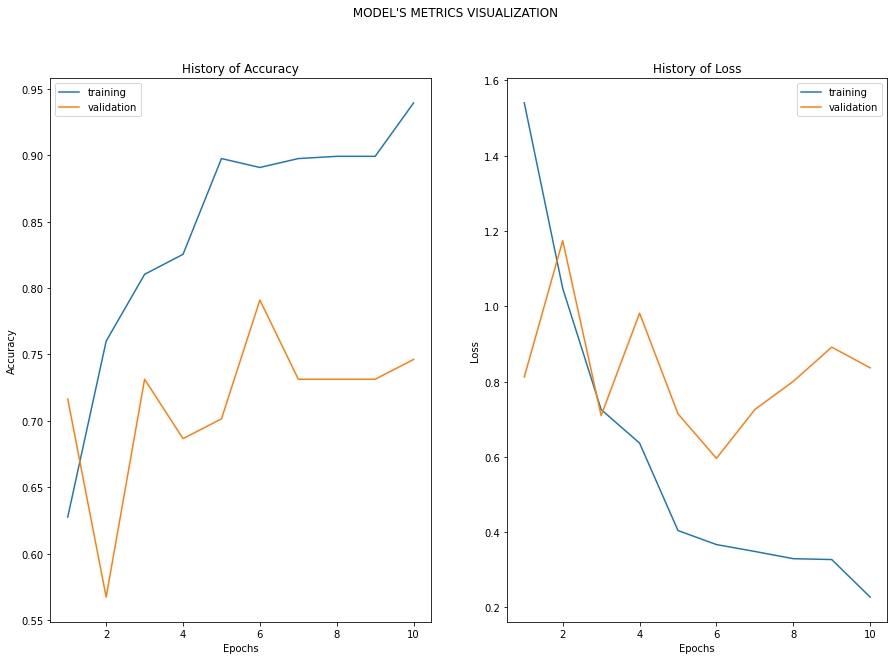

In [16]:
model = VGG16()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,30,4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

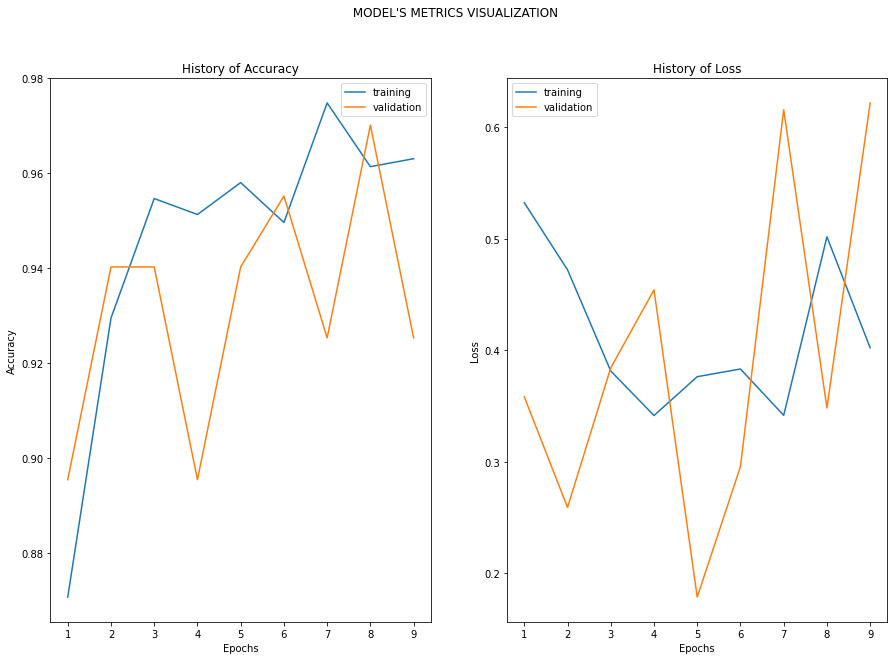

In [17]:
model = VGG16()
model.summary()
fit_evaluate(model,Xm_train,ym_train,Xm_test,ym_test,16,30,4)

In [18]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None
)

for l in base_model.layers:
    l.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [19]:
def VGG19():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                      

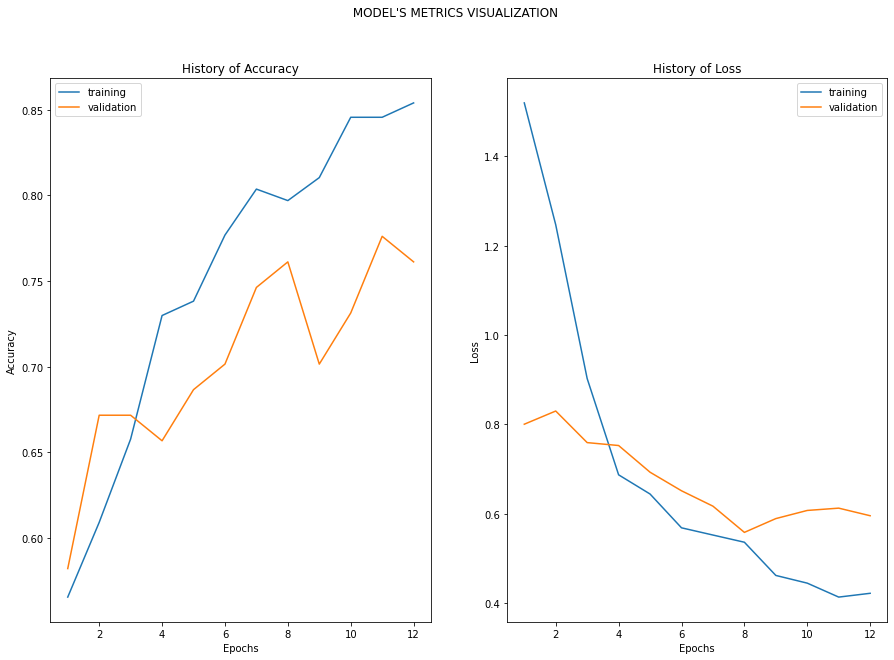

In [20]:
model = VGG19()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,30,4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                      

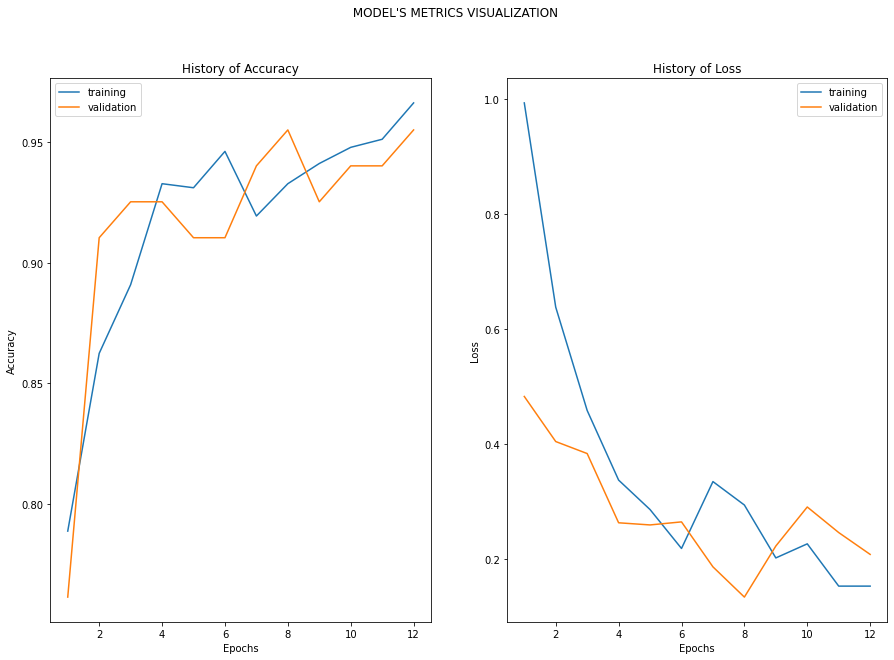

In [21]:
model = VGG19()
model.summary()
fit_evaluate(model,Xm_train,ym_train,Xm_test,ym_test,16,30,4)